## East Baton Rouge Parish, LA 2020 Metro Council Election Results and Boundaries

### Sections
- <a href="#join">Read in Input Files and Join</a><br>
- <a href="#shp">Create Ward Boundaries</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Datasets</a><br>

#### Sources

- [Louisiana Secretary of State - East Baton Rouge Parish, LA 2020 Election Returns](https://voterportal.sos.la.gov/static/2020-11-03/resultsRace/17) 
- [East Baton Rouge Parish Metro Council District PDF Maps](https://www.brla.gov/561/Metropolitan-Council)
        - PDF map for each district found under 'documents' under each metro council member's webpage
- [VEST 2020 General Election Returns - Precint Level](https://redistrictingdatahub.org/dataset/vest-2020-louisiana-precinct-and-election-results/)

In [1]:
import pandas as pd
import geopandas as gp
import os
import re
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

##### RDH Function to allocate absentee or early votes

In [2]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum(numeric_only=True))
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1
                            special_allocation_needed.append([race_district,race])
    if(len(special_allocation_needed) > 0):
        print("Special allocation used for", special_allocation_needed)

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum(numeric_only=True))

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

#### RDH Function to check vote totals

In [3]:
def county_totals_check(partner_df, partner_name, source_df, source_name, column_list, county_col, full_print=False, method="race"):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    
    if method == "race":
        diff_counties=[]
        for race in column_list:
            diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
            for val in diff[diff != 0].index.values.tolist():
                if val not in diff_counties:
                    diff_counties.append(val)
            if len(diff[diff != 0]!=0):   
                print(race + " contains differences in these counties:")
                for val in diff[diff != 0].index.values.tolist():
                    county_differences = diff[diff != 0]
                    print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                    print("\t\t"+ partner_name + ": "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                    print("\t\t"+ source_name +": "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
                if (full_print):
                    for val in diff[diff == 0].index.values.tolist():
                        county_similarities = diff[diff == 0]
                        print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
            else:
                print(race + " is equal across all counties")
                if (full_print):
                    for val in diff[diff == 0].index.values.tolist():
                        county_similarities = diff[diff == 0]
                        print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        if (len(diff_counties)>0):
            print()
            diff_counties.sort()
            print(diff_counties)
    elif method == "county":
        if set(source_df[county_col].unique()) != set(partner_df[county_col].unique()):
            raise ValueError("Not all counties will be checked")
        diff_counties=[]
        good_counties=[]
        holder_1 = partner_df.groupby(county_col).sum()
        holder_2 = source_df.groupby(county_col).sum()
        for county in list(partner_df[county_col].unique()):
            no_diff = True
            for race in column_list:
                partner_val = holder_1.loc[county][race]
                source_val =  holder_2.loc[county][race]
                diff = partner_val - source_val
                if diff != 0:
                    if no_diff:
                        print(f"{county} contains differences in these races:")
                        no_diff = False
                    print(f"\t{race} has a difference of {diff} vote(s)")
                    print(f"\t\t{partner_name}: {partner_val} vote(s)")
                    print(f"\t\t{source_name}: {source_val} vote(s)")
            if no_diff:
                good_counties.append(county)
            else:
                diff_counties.append(county)
        if (len(diff_counties)>0):
            print()
            diff_counties.sort()
            print(diff_counties)
        print("Counties that match:")
        if (len(good_counties)>0):
            print()
            good_counties.sort()
            print(good_counties)
    else:
        raise ValueError("Enter a correct method: race or county")

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from Louisiana SOS website to machine readable format, and checked for accuracy.

In [4]:
#Election Returns
er_raw = pd.read_csv("./raw-from-source/LA20_EASTBATONROUGE_ER.csv").fillna(0)
er_raw['UNIQUE_ID'] = 'EAST BATON ROUGE' + "-:-" + er_raw['PRECINCT'].astype(str)
er_raw.head()

,UNIQUE_ID,MNCIPAL,PRECINCT,G20MYRDBRO,G20MYRRCAR,G20MYRIGUI,G20MYRDMAR,G20MYRRPIA,G20MYRRSMI,G20MYRRWAT,GCNC1RADD,GCNC1DLEW,GCNC1RNOE,GCNC2DBAN,GCNC2DJEM,GCNC2DJOH,GCNC2DWIL,GCNC4DJAM,GCNC4RMCC,GCNC4RMOA,GCNC4RVIC,GCNC5DGRE,GCNC5DHUR,GCNC6DCOL,GCNC6DDUN,GCNC6IKAU,GCNC6DPIT,GCNC6DSMC,GCNC6DSMP,GCNC7LBAU,GCNC7LBEL,GCNC7DCOL,GCNC7DBRO,GCNC7DJRO,GCNC7DSMI,GCNC8RAMO,GCNC8DPIP,GCNC9RHUD,GCNC9RMOR,GCNC10DAND,GCNC10DCCO,GCNC10DECO,GCNC10DCOS,GCNC10DCOT,GCNC10DGAU,GCNC10DLEW,GCNC11RADA,GCNC11RBAR,GCNC11RSNY,GCNC12NMYE,GCNC12DNYM,GCNC12RRAC
0,EAST BATON ROUGE-:-01 001,EAST BATON ROUGE,01 001,169,52,10,21,40,3,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,49.0,19.0,16.0,9.0,86.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EAST BATON ROUGE-:-01 002 A,EAST BATON ROUGE,01 002 A,167,6,1,77,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,69.0,6.0,47.0,35.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EAST BATON ROUGE-:-01 002 B,EAST BATON ROUGE,01 002 B,174,5,5,52,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,61.0,11.0,30.0,36.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EAST BATON ROUGE-:-01 003,EAST BATON ROUGE,01 003,153,5,3,32,6,1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,69.0,28.0,15.0,3.0,31.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EAST BATON ROUGE-:-01 004,EAST BATON ROUGE,01 004,159,0,5,28,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,69.0,40.0,13.0,2.0,14.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#subset precinct names for cleaning, exclude early voting row and total row
ebr_precs = er_raw[['PRECINCT']][:-2]

In [6]:
ebr_precs.head()

,PRECINCT
0,01 001
1,01 002 A
2,01 002 B
3,01 003
4,01 004


In [7]:
#Clean precinct names
ebr_precs['CLEAN'] = ebr_precs['PRECINCT'].astype(str)
#remove leading zeros, recombine string
ebr_precs['CLEAN'] = ebr_precs['CLEAN'].apply(lambda x: '-'.join([str(int(part)) for part in x.split() if part.isdigit()]))

In [8]:
#Create rename dictionary
prec_rename_dict = dict(zip(ebr_precs['PRECINCT'], ebr_precs['CLEAN']))

In [9]:
#prepare for vote allocation
er_rec = er_raw.iloc[:-2]
er_alloc = er_raw.iloc[-2:-1]
er_total = er_raw.iloc[-1:]

In [10]:
vote_cols = list(er_raw.columns[3:])
#check print(vote_cols)

In [11]:
#rename precincts in er_rec
er_rec['PRECINCT'].replace(prec_rename_dict, inplace=True)

C:\Users\aditi\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [12]:
er_rec.head()

,UNIQUE_ID,MNCIPAL,PRECINCT,G20MYRDBRO,G20MYRRCAR,G20MYRIGUI,G20MYRDMAR,G20MYRRPIA,G20MYRRSMI,G20MYRRWAT,GCNC1RADD,GCNC1DLEW,GCNC1RNOE,GCNC2DBAN,GCNC2DJEM,GCNC2DJOH,GCNC2DWIL,GCNC4DJAM,GCNC4RMCC,GCNC4RMOA,GCNC4RVIC,GCNC5DGRE,GCNC5DHUR,GCNC6DCOL,GCNC6DDUN,GCNC6IKAU,GCNC6DPIT,GCNC6DSMC,GCNC6DSMP,GCNC7LBAU,GCNC7LBEL,GCNC7DCOL,GCNC7DBRO,GCNC7DJRO,GCNC7DSMI,GCNC8RAMO,GCNC8DPIP,GCNC9RHUD,GCNC9RMOR,GCNC10DAND,GCNC10DCCO,GCNC10DECO,GCNC10DCOS,GCNC10DCOT,GCNC10DGAU,GCNC10DLEW,GCNC11RADA,GCNC11RBAR,GCNC11RSNY,GCNC12NMYE,GCNC12DNYM,GCNC12RRAC
0,EAST BATON ROUGE-:-01 001,EAST BATON ROUGE,1-1,169,52,10,21,40,3,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,49.0,19.0,16.0,9.0,86.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EAST BATON ROUGE-:-01 002 A,EAST BATON ROUGE,1-2,167,6,1,77,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,69.0,6.0,47.0,35.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EAST BATON ROUGE-:-01 002 B,EAST BATON ROUGE,1-2,174,5,5,52,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,61.0,11.0,30.0,36.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EAST BATON ROUGE-:-01 003,EAST BATON ROUGE,1-3,153,5,3,32,6,1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,69.0,28.0,15.0,3.0,31.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EAST BATON ROUGE-:-01 004,EAST BATON ROUGE,1-4,159,0,5,28,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,69.0,40.0,13.0,2.0,14.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Vote Allocation for Early Votes

In [13]:
er_final = allocate_absentee(er_rec,er_alloc,vote_cols,"MNCIPAL",allocating_to_all_empty_precs=False)

In [14]:
er_final.head()

,UNIQUE_ID,MNCIPAL,PRECINCT,G20MYRDBRO,G20MYRRCAR,G20MYRIGUI,G20MYRDMAR,G20MYRRPIA,G20MYRRSMI,G20MYRRWAT,GCNC1RADD,GCNC1DLEW,GCNC1RNOE,GCNC2DBAN,GCNC2DJEM,GCNC2DJOH,GCNC2DWIL,GCNC4DJAM,GCNC4RMCC,GCNC4RMOA,GCNC4RVIC,GCNC5DGRE,GCNC5DHUR,GCNC6DCOL,GCNC6DDUN,GCNC6IKAU,GCNC6DPIT,GCNC6DSMC,GCNC6DSMP,GCNC7LBAU,GCNC7LBEL,GCNC7DCOL,GCNC7DBRO,GCNC7DJRO,GCNC7DSMI,GCNC8RAMO,GCNC8DPIP,GCNC9RHUD,GCNC9RMOR,GCNC10DAND,GCNC10DCCO,GCNC10DECO,GCNC10DCOS,GCNC10DCOT,GCNC10DGAU,GCNC10DLEW,GCNC11RADA,GCNC11RBAR,GCNC11RSNY,GCNC12NMYE,GCNC12DNYM,GCNC12RRAC
0,EAST BATON ROUGE-:-01 001,EAST BATON ROUGE,1-1,353,99,15,34,62,5,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,73,32,25,14,150,98,0,0,0,0,0,0
1,EAST BATON ROUGE-:-01 002 A,EAST BATON ROUGE,1-2,349,11,2,126,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,126,10,99,64,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,EAST BATON ROUGE-:-01 002 B,EAST BATON ROUGE,1-2,364,10,8,85,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,112,18,63,66,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,EAST BATON ROUGE-:-01 003,EAST BATON ROUGE,1-3,320,10,5,52,9,2,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,103,47,24,5,54,30,0,0,0,0,0,0
4,EAST BATON ROUGE-:-01 004,EAST BATON ROUGE,1-4,333,0,8,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,103,68,21,3,25,39,0,0,0,0,0,0


### Vote Totals Check

In [15]:
county_totals_check(er_total, 'SOS', er_final, 'RDH', vote_cols, 'MNCIPAL', full_print = False, method = "county")

***Countywide Totals Check***

Counties that match:

['EAST BATON ROUGE']


## VEST 2020 Shapefile

VEST's 2020 General Election shapefile read in and subset to East Baton Rouge Parish Precincts.
FIPS = 033

In [16]:
# Read in VEST 2020
vest_2020 = gp.read_file("./raw-from-source/la_vest_20/la_vest_20.shp") 

In [17]:
#subset
ebr_shp = vest_2020[vest_2020['COUNTYFP'] == '033'][['NAME', 'geometry']]

<AxesSubplot:>

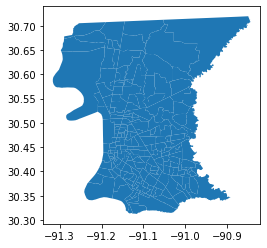

In [18]:
#Check
ebr_shp.plot()

In [19]:
ebr_shp.head()

,NAME,geometry
771,1-1,"POLYGON Z ((-91.19621 30.45779 0.00000, -91.19..."
772,1-2,"POLYGON Z ((-91.13013 30.46757 0.00000, -91.12..."
773,1-3,"POLYGON Z ((-91.18739 30.43972 0.00000, -91.18..."
774,1-35,"POLYGON Z ((-91.14309 30.44442 0.00000, -91.14..."
775,1-44,"POLYGON Z ((-91.17821 30.42182 0.00000, -91.17..."


In [20]:
#check
ebr_shp['NAME'].nunique()

213

PDF metro council maps were manually referenced to match precincts to appropriate council districts

In [21]:
#Read in crosswalk
prec_dist_dict = pd.read_csv("./raw-from-source/EBR_PREC_DIST_DICT.csv")

In [22]:
#clean up
ebr_shp['DISTRICT'] = ebr_shp['NAME']
ebr_shp = ebr_shp[['NAME', 'DISTRICT', 'geometry']]
ebr_shp.columns = ['PRECINCT', 'DISTRICT', 'geometry']

In [23]:
#Assign precincts to districts
#create rename dict
dist_rename_dict = dict(zip(prec_dist_dict['UNIQUE_ID'], prec_dist_dict['COUNC_DIST']))

In [24]:
ebr_shp['DISTRICT'].replace(dist_rename_dict, inplace=True)

C:\Users\aditi\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [25]:
ebr_shp.head()

,PRECINCT,DISTRICT,geometry
771,1-1,10,"POLYGON Z ((-91.19621 30.45779 0.00000, -91.19..."
772,1-2,6,"POLYGON Z ((-91.13013 30.46757 0.00000, -91.12..."
773,1-3,10,"POLYGON Z ((-91.18739 30.43972 0.00000, -91.18..."
774,1-35,7,"POLYGON Z ((-91.14309 30.44442 0.00000, -91.14..."
775,1-44,10,"POLYGON Z ((-91.17821 30.42182 0.00000, -91.17..."


In [26]:
#check
type(ebr_shp)

geopandas.geodataframe.GeoDataFrame

In [27]:
#dissolve
ebr_dist = ebr_shp[['DISTRICT', 'geometry']].dissolve(by='DISTRICT').reset_index()

In [28]:
#Add unique ID col
ebr_dist['DISTRICT'] = ebr_dist['DISTRICT'].astype(str)
ebr_dist['UNIQUE_ID'] = 'EASTBATONROUGE_METRODIST_' + ebr_dist['DISTRICT']
#subset
ebr_dist = ebr_dist[['UNIQUE_ID', 'geometry']]

In [29]:
#Check
ebr_dist.head()

,UNIQUE_ID,geometry
0,EASTBATONROUGE_METRODIST_1,"POLYGON Z ((-91.31280 30.59752 0.00000, -91.30..."
1,EASTBATONROUGE_METRODIST_2,"POLYGON Z ((-91.17986 30.52056 0.00000, -91.18..."
2,EASTBATONROUGE_METRODIST_3,"POLYGON Z ((-91.09300 30.32059 0.00000, -91.09..."
3,EASTBATONROUGE_METRODIST_4,"POLYGON Z ((-91.03422 30.44552 0.00000, -91.03..."
4,EASTBATONROUGE_METRODIST_5,"POLYGON Z ((-91.15555 30.49270 0.00000, -91.15..."


<AxesSubplot:>

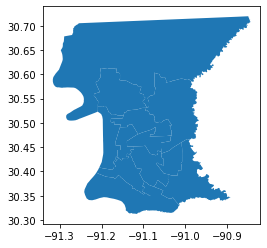

In [30]:
ebr_dist.plot()

### Join precinct shapes with At Large Election Returns

In [31]:
# merge
ebr_pber = er_final.merge(ebr_shp, on='PRECINCT', how = 'right', indicator=True)

In [32]:
#check indicator to see if merge was successful
ebr_pber._merge.value_counts()

both          329
left_only       0
right_only      0
Name: _merge, dtype: int64

In [33]:
#Drop merge column
ebr_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [34]:
#Geodf
ebr_pber = gp.GeoDataFrame(ebr_pber, geometry='geometry')
#check
type(ebr_pber)

geopandas.geodataframe.GeoDataFrame

In [35]:
#dissolve on precincts
#dissolve
ebr_pber_final = ebr_pber.dissolve(by='PRECINCT', aggfunc='sum').reset_index()

In [36]:
ebr_pber_final['MNCIPAL'] = 'EAST BATON ROUGE'
ebr_pber_final.head(2)

,PRECINCT,geometry,G20MYRDBRO,G20MYRRCAR,G20MYRIGUI,G20MYRDMAR,G20MYRRPIA,G20MYRRSMI,G20MYRRWAT,GCNC1RADD,GCNC1DLEW,GCNC1RNOE,GCNC2DBAN,GCNC2DJEM,GCNC2DJOH,GCNC2DWIL,GCNC4DJAM,GCNC4RMCC,GCNC4RMOA,GCNC4RVIC,GCNC5DGRE,GCNC5DHUR,GCNC6DCOL,GCNC6DDUN,GCNC6IKAU,GCNC6DPIT,GCNC6DSMC,GCNC6DSMP,GCNC7LBAU,GCNC7LBEL,GCNC7DCOL,GCNC7DBRO,GCNC7DJRO,GCNC7DSMI,GCNC8RAMO,GCNC8DPIP,GCNC9RHUD,GCNC9RMOR,GCNC10DAND,GCNC10DCCO,GCNC10DECO,GCNC10DCOS,GCNC10DCOT,GCNC10DGAU,GCNC10DLEW,GCNC11RADA,GCNC11RBAR,GCNC11RSNY,GCNC12NMYE,GCNC12DNYM,GCNC12RRAC,DISTRICT,MNCIPAL
0,1-1,"POLYGON Z ((-91.19621 30.45779 0.00000, -91.19...",353,99,15,34,62,5,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,73,32,25,14,150,98,0,0,0,0,0,0,10,EAST BATON ROUGE
1,1-10,"POLYGON Z ((-91.16654 30.46166 0.00000, -91.16...",604,2,5,203,4,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,91,320,58,123,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,EAST BATON ROUGE


### Final Vote Check

In [37]:
county_totals_check(er_total, 'SOS', ebr_pber_final, 'RDH', vote_cols, 'MNCIPAL', full_print = False, method = "county")

***Countywide Totals Check***

Counties that match:

['EAST BATON ROUGE']


In [38]:
#REDO UNIQUE_ID COL
ebr_pber_final['UNIQUE_ID'] = ebr_pber_final['MNCIPAL'] + '-:-' + ebr_pber_final['PRECINCT']

In [39]:
#Rearrange columns
ebr_pber_final = ebr_pber_final[['UNIQUE_ID', 'MNCIPAL', 'PRECINCT', 'DISTRICT'] + vote_cols + ['geometry']]

In [40]:
#Fix districts
ebr_pber_final['DISTRICT'] = ebr_pber_final['PRECINCT']
ebr_pber_final['DISTRICT'].replace(dist_rename_dict, inplace=True)

In [41]:
#check
ebr_pber_final.head()

,UNIQUE_ID,MNCIPAL,PRECINCT,DISTRICT,G20MYRDBRO,G20MYRRCAR,G20MYRIGUI,G20MYRDMAR,G20MYRRPIA,G20MYRRSMI,G20MYRRWAT,GCNC1RADD,GCNC1DLEW,GCNC1RNOE,GCNC2DBAN,GCNC2DJEM,GCNC2DJOH,GCNC2DWIL,GCNC4DJAM,GCNC4RMCC,GCNC4RMOA,GCNC4RVIC,GCNC5DGRE,GCNC5DHUR,GCNC6DCOL,GCNC6DDUN,GCNC6IKAU,GCNC6DPIT,GCNC6DSMC,GCNC6DSMP,GCNC7LBAU,GCNC7LBEL,GCNC7DCOL,GCNC7DBRO,GCNC7DJRO,GCNC7DSMI,GCNC8RAMO,GCNC8DPIP,GCNC9RHUD,GCNC9RMOR,GCNC10DAND,GCNC10DCCO,GCNC10DECO,GCNC10DCOS,GCNC10DCOT,GCNC10DGAU,GCNC10DLEW,GCNC11RADA,GCNC11RBAR,GCNC11RSNY,GCNC12NMYE,GCNC12DNYM,GCNC12RRAC,geometry
0,EAST BATON ROUGE-:-1-1,EAST BATON ROUGE,1-1,10,353,99,15,34,62,5,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,73,32,25,14,150,98,0,0,0,0,0,0,"POLYGON Z ((-91.19621 30.45779 0.00000, -91.19..."
1,EAST BATON ROUGE-:-1-10,EAST BATON ROUGE,1-10,7,604,2,5,203,4,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,91,320,58,123,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-91.16654 30.46166 0.00000, -91.16..."
2,EAST BATON ROUGE-:-1-100,EAST BATON ROUGE,1-100,10,454,4,11,66,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,122,94,78,27,13,53,36,0,0,0,0,0,0,"POLYGON Z ((-91.20891 30.52609 0.00000, -91.20..."
3,EAST BATON ROUGE-:-1-101,EAST BATON ROUGE,1-101,2,439,4,3,55,2,2,6,0,0,0,288,36,66,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-91.19821 30.55172 0.00000, -91.19..."
4,EAST BATON ROUGE-:-1-102,EAST BATON ROUGE,1-102,12,494,76,29,80,42,2,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,612,157,"POLYGON Z ((-91.21281 30.39709 0.00000, -91.21..."


In [42]:
#Geodf
ebr_pber_final = gp.GeoDataFrame(ebr_pber_final, geometry='geometry')
#check
type(ebr_pber_final)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

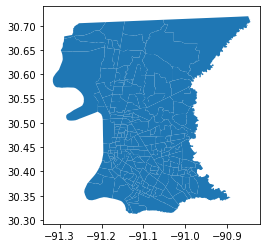

In [43]:
#check
ebr_pber_final.plot()

<p><a name="exp"></a></p>

### Export Cleaned Datasets

In [44]:
if not os.path.exists("./LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER"):
    os.mkdir("./LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER")

ebr_dist.to_file("./LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_DIST.shp")
ebr_pber_final.to_file("./LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER.shp")

In [45]:
def check_file(path):
    if ".csv" in path:
        file_type = ".csv"
        load = pd.read_csv(path)
    elif ".shp" in path:
        file_type = ".shp"
        load = gp.read_file(path)
        assert(os.path.exists(path[0:-4] + ".cpg"))
        assert(os.path.exists(path[0:-4] + ".dbf"))
        assert(os.path.exists(path[0:-4] + ".prj"))
        assert(os.path.exists(path[0:-4] + ".shx"))
    else:
        raise ValueError ("Other function needed to load non .csv or .shp")
    run_checks(load, path, file_type)
    
def run_checks(file, path, file_type):
    if "/Users" in path:
        path = path.replace("/Users","")
    path_name = path.replace("/","-")
    
        
    with open("./FILE_CHECK" + path_name + ".txt","w") as t:
        t.write("***RDH FILE CHECKER***\n")
        t.write("Checking file located at " + path+"\n")
        t.write("\n")
        t.write("\n")        
        
        t.write("***N/A VALUES***\n")
        if(file.isna().any().sum() != 0):
            t.write("N/A values in the following columns\n")
            for col in file.columns:
                num_nas = file[col].isna().sum()
                string_nans = file[file[col]=="nan"].shape[0]
                if file[col].isna().any().sum():
                    t.write("\t"+col+" - "+ str(num_nas) +" row(s)\n")
                elif  string_nans > 0:
                    t.write("\t"+col+" - "+ str(string_nans) +" row(s)\n")

        else:
            t.write("Do not appear to be N/A values")
        t.write("\n")
        t.write("\n")
        
        t.write("***File Size***\n")
        t.write("File contains " + str(file.shape[0]) + " row(s)\n")
        t.write("File contains " + str(file.shape[1]) + " column(s)\n")
        t.write("\n")
        t.write("\n")
        
        if file_type == ".shp":
            t.write("***Invalid Geometries***\n")
            t.write("File contains " + str(file[~file["geometry"].is_valid].shape[0]) + " invalid GEOM row(s)\n")
            t.write("File contains " + str(file[file["geometry"].is_valid].shape[0]) + " valid GEOM row(s)\n")
            t.write("\n")
            t.write("\n")

        t.write("***COLUMN NAMES***\n")
        t.write(str(list(file.columns)))
        t.write("\n")
        t.write("\n")
        
        t.write("***COLUMN NAME LENGTHS***\n")
        long_col_name_list = [i for i in file.columns if len(i) > 10]
        if len(long_col_name_list) > 0:
            t.write("The following columns are longer than 10 characters:" + str(long_col_name_list)+"\n")
        else:
            t.write("No column names are longer than 10 characters\n")
        t.write("\n")
        t.write("\n")

        t.write("***FULL FILE SUMMARY***\n")
        t.write(str(file.describe())+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***MAX VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.max()) + "\n")
        t.write("\n")
        t.write("\n")

        t.write("***MIN VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.min()) + "\n")
        t.write("\n")
        
        t.write("***NUMERIC COLUMN SUMS***\n")
        t.write(str(file.sum(numeric_only=True))+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***COLUMNS AND DUPLICATE VALUES***\n")
        for col in list(file.columns):
            if col != "geometry":
                if max(file[col].value_counts(dropna = False))==1:
                    t.write("NO: Column " + col + " DOES NOT HAVE duplicate values\n")
                elif max(file[col].value_counts(dropna = False))>1:
                    t.write("YES: Column " + col+ " HAS duplicate values\n")
        t.write("\n")


In [46]:
check_file("./LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER/LA20_EASTBATONROUGE_PBER.shp")

#### Compressing pdfs